**Variable	Description**

* Item_Identifier	==> Unique product ID
* Item_Weight	==> Weight of product
* Item_Fat_Content ==> Whether the product is low fat or not
* Item_Visibility	==> The % of total display area of all products in a store allocated to the particular product
* Item_Type	==> The category to which the product belongs
* Item_MRP	==> Maximum Retail Price (list price) of the product
* Outlet_Identifier	==> Unique store ID
* Outlet_Establishment_Year	==> The year in which store was established
* Outlet_Size	==> The size of the store in terms of ground area covered
* Outlet_Location_Type	==> The type of city in which the store is located
* Outlet_Type	==> Whether the outlet is just a grocery store or some sort of supermarket
* Item_Outlet_Sales	==> Sales of the product in the particular store. This is the outcome variable to be predicted.

In [1]:
path = "C:/Users/Chigozie/Documents/data science/analyticsvidya_data/bigMartSales"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression

In [8]:
import skopt
from skopt.plots import plot_convergence
from skopt.space import Categorical, Integer, Real, sp_version, Space
from skopt.utils import use_named_args
from skopt import gp_minimize
from functools import partial

In [7]:
sp_version

'0.8.1'

In [9]:
#FOR PREPRODUCIBILITY
seed= 2020
np.random.seed(seed)

In [10]:
%matplotlib inline
pd.set_option('display.max_columns', 50)
plt.style.use('bmh')

In [11]:
def randomColors(seed=42):
    """
    Random color generator
    :Returns Hex colors
    """
    np.random.RandomState(seed)
    colors = [i for i in range(0,10)]+['A', 'B', 'C', 'D', 'E']
    color= np.random.choice(colors, 6, replace=False)
    return '#'+''.join(color)

In [12]:
train = pd.read_csv(path+'/Train_cleaned.csv')
test = pd.read_csv(path+'/Test_cleaned.csv')
subfile = pd.read_table(path+'/SampleSubmission.txt', sep=',')

In [13]:
train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Store_Unique_Items,Store_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,3,Tier 1,Supermarket Type1,3735.1380,9,21
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,3,Tier 3,Supermarket Type2,443.4228,9,11
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,3,Tier 1,Supermarket Type1,2097.2700,10,21


In [14]:
test.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Store_Unique_Items,Store_Age
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,3,Tier 1,Supermarket Type1,9,21
1,FDW14,8.30,Regular,0.038428,Dairy,87.3198,OUT017,2007,1,Tier 2,Supermarket Type1,9,13
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,1,Tier 3,Grocery Store,9,22


In [15]:
test_ids = test[['Item_Identifier', 'Outlet_Identifier']]

**In the EDA section, I had replaced outlets whose sizes are missing with "Unk" (which was replaced with 1), let's investigate further and look for a more appropriate way to fill in the missing values**

* One way is to find the most frequent size of other outlets within its location type and the Outlet Type.
* Another is to group the Outlets, their location and types with the Outlet size.

In [16]:
train[train.Outlet_Size == 1].Outlet_Identifier.unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [17]:
train.groupby(['Outlet_Location_Type', 'Outlet_Identifier','Outlet_Type']).Outlet_Size.first()

Outlet_Location_Type  Outlet_Identifier  Outlet_Type      
Tier 1                OUT019             Grocery Store        2
                      OUT046             Supermarket Type1    2
                      OUT049             Supermarket Type1    3
Tier 2                OUT017             Supermarket Type1    1
                      OUT035             Supermarket Type1    2
                      OUT045             Supermarket Type1    1
Tier 3                OUT010             Grocery Store        1
                      OUT013             Supermarket Type1    4
                      OUT018             Supermarket Type2    3
                      OUT027             Supermarket Type3    3
Name: Outlet_Size, dtype: int64

* **`As we can see Outlet OUT010 is in Tier3 location and is a grocery store, while Outlets 017 and 045 are in Tier 2 and are Supermarket stores.`**
* **`For Outlet 10, we will replace its size with 2 (ie Small), reason is that if we look at Grocery store in Tier 3, it is only Outlet 10, hence the 1 (Unk), so we will replace it with that for Tier 2 (which is Outlet 19)`**
* **`For Outlets 17 and 45, we will replace with 2 (ie size for Outlet 35), since outlets 17, 35 and 45 are found within Tier 2 and are all SuperMarket Type1`**

In [18]:
train.loc[train.Outlet_Identifier == 'OUT010', 'Outlet_Size'] = 2
test.loc[test.Outlet_Identifier == 'OUT010', 'Outlet_Size'] = 2

train.loc[train.Outlet_Identifier.isin(['OUT017', 'OUT045']), 'Outlet_Size'] = 2
test.loc[test.Outlet_Identifier.isin(['OUT017', 'OUT045']), 'Outlet_Size'] = 2

In [19]:
#decreasing the vaue by 1 (so that it can have 1,2,3)
train.Outlet_Size -= 1
test.Outlet_Size -= 1

**More Feature Engineering**

1. Grouping Products into Categories (foods, Drinks and Non-consumables)
2. Size of the Display Area in each Outlet
3. Percentage of Display Area given to products in similar Cateogory (ie Foods, Drinks and Non-Consumables)
4. Rank of Outlets based on total revenues generated.
5. Item Weight Visibility
6. Item code
7. Average retail price by item code and item type
8. Expected Revenue to be generated from an outlet.
8. Expected Revenue to be generated from an Item in each outlet

In [20]:
train['Item_Category'] = train.Item_Identifier.transform(lambda x: x[:-3]).replace({
    'FD' : 'Food', 'DR' : 'Drink', 'NC' : 'Non-Consumables'})

test['Item_Category'] = test.Item_Identifier.transform(lambda x: x[:-3]).replace({
    'FD' : 'Food', 'DR' : 'Drink', 'NC' : 'Non-Consumables'})

In [21]:
df = train.append(test)[train.columns]

In [22]:
store_display_area = df.groupby(['Outlet_Identifier']).Item_Visibility.apply(lambda x: x.sum().round(3)).to_dict()

In [23]:
Item_cat_disp_area = df.groupby(['Outlet_Identifier', 'Item_Category']).Item_Visibility.apply(
    lambda x: x.sum().round(2)).groupby(['Item_Category']).apply(np.mean).to_dict()

In [24]:
train['Store_tot_Visibility'] = train.Outlet_Identifier.map(store_display_area)
test['Store_tot_Visibility'] = test.Outlet_Identifier.map(store_display_area)

In [25]:
train['ItemCat_tot_Visibility'] = train.Item_Category.map(Item_cat_disp_area)
test['ItemCat_tot_Visibility'] = test.Item_Category.map(Item_cat_disp_area)

In [26]:
train['Item_Weight_Visibility'] = train.Item_Weight * train.Item_Visibility
test['Item_Weight_Visibility'] = test.Item_Weight * test.Item_Visibility

In [27]:
train['Item_code'] = train.Item_Identifier.transform(lambda x: x[:-2])
test['Item_code'] = test.Item_Identifier.transform(lambda x: x[:-2])

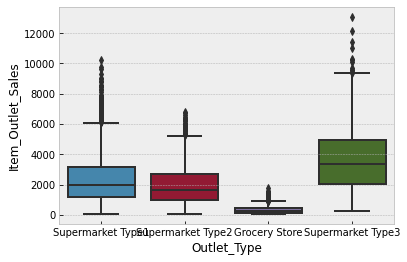

In [28]:
sns.boxplot(train.Outlet_Type, train.Item_Outlet_Sales);

In [29]:
train['Is_Supermarket'] = train.Outlet_Type.str.contains('market') * 1
test['Is_Supermarket'] = test.Outlet_Type.str.contains('market') * 1

train['Is_Supermarket3'] = (train.Outlet_Type == 'Supermarket Type3') * 1
test['Is_Supermarket3'] = (test.Outlet_Type == 'Supermarket Type3') * 1

train['is_StoreID27'] = (train.Outlet_Identifier == 'OUT027') *1
test['is_StoreID27'] = (test.Outlet_Identifier == 'OUT027') * 1

In [30]:
train['Item_weight_MRP'] = train.Item_MRP * train.Item_Weight
test['Item_weight_MRP'] = test.Item_MRP * test.Item_Weight

train['Item_weight_MRP_Vis'] = train.Item_MRP * train.Item_Weight * train.Item_Visibility
test['Item_weight_MRP_Vis'] = test.Item_MRP * test.Item_Weight * test.Item_Visibility

In [31]:
train['Item_code_StoreID'] = train.Item_code + '__' + train.Outlet_Identifier
test['Item_code_StoreID'] = test.Item_code + '__' + test.Outlet_Identifier

In [32]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']

In [33]:
cat_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Category',
 'Item_code',
 'Item_code_StoreID']

**Label Encoding**

In [34]:
for col in cat_cols:
    lb_enc = LabelEncoder()
    lb_enc.fit(train.append(test)[col])
    train[col] = lb_enc.transform(train[col])
    test[col] = lb_enc.transform(test[col])

In [35]:
features = train.columns.drop(['Item_Outlet_Sales'])

In [36]:
def model_train(model, df, test_df, n_folds=5):
    """
    Function for Training Model
    :params model: Instantiated model
    :params df: Train data
    :params test_df: Test_data
    :returns test_predictions
    """
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    for f, (tr_idx, val_idx) in enumerate(kfold.split(
        df.drop('Item_Outlet_Sales', axis=1), df.Item_Outlet_Sales)):
        
        df.loc[val_idx, 'kfold'] = f
    
    #shuffling data
    df = df.sample(frac=1, random_state=seed)#seed for reproducibility
    
    features =  [col for col in df.columns if col not in ['Item_Outlet_Sales', 'kfold']]
    
    tr_avg, val_avg = 0, 0
    test_preds= []
    train_preds = np.zeros(len(df))
    xtest = test_df #test set
    
    for fold_ in range(n_folds):
        
        train_df = df[df.kfold != fold_]
        val_df = df[df.kfold == fold_]
        
        xtrain, ytrain = train_df[features], np.log(train_df.Item_Outlet_Sales)
        xval, yval = val_df[features], np.log(val_df.Item_Outlet_Sales)
        
        #fitting
        if model.__class__.__name__ in ['XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor']:
            model.fit(xtrain, ytrain, eval_set=[(xval, yval)], early_stopping_rounds=300, verbose=False)
        else:       
            model.fit(xtrain, ytrain)
        
        preds = model.predict(xval)
        val_rmse = mean_squared_error(np.exp(yval), np.exp(preds), squared=False) #Squaring both actual and predictions
        tr_rmse = mean_squared_error(np.exp(ytrain), np.exp(model.predict(xtrain)), squared=False)
        
        tr_avg += tr_rmse
        val_avg += val_rmse
        
        train_pred = np.exp(model.predict(xval))
        train_preds[val_df.index] = train_pred
        #predicting Test set
        test_pred = np.exp(model.predict(xtest[features]))
        test_preds.append(test_pred)
        
        print(f'Fold {fold_+1}\tTrain RMSE: {tr_rmse.round(4)}, Val RMSE: {val_rmse.round(4)}')
    print()
    print(f'AVG Train RMSE: {(tr_avg/(n_folds)).round(4)}, AVG Val RMSE: {(val_avg/n_folds).round(4)}')
    return np.mean(test_preds, 0).astype('float32'), train_preds.astype('float32')

In [37]:
def StackModels(meta_estimator, train_stack, test_stack, target):
    preds = meta_estimator.fit(train_stack, target).predict(test_stack)
    return preds

In [38]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=400, min_samples_leaf=10, max_samples=0.8,
                           min_samples_split=5, random_state=seed, max_features=0.5)

gbm = GradientBoostingRegressor(n_estimators=700, max_depth=3, max_features=0.5, validation_fraction=0.1, 
                                learning_rate=0.06, min_samples_leaf=3, random_state=seed, min_samples_split=2, 
                                n_iter_no_change=100, subsample=1.)

lgbm = lgb.LGBMRegressor(n_estimators=900, learning_rate=0.009, min_child_samples=20, min_child_weight=3,
                         metrics='rmse', max_depth=3, num_leaves=20, colsample_bytree=0.7, 
                         subsample_freq=2, random_state=seed, reg_lambda=3, subsample=0.8)

catm  = cat.CatBoostRegressor(random_seed=seed, learning_rate=0.015, n_estimators=900, silent=True, rsm=0.7, 
                              bootstrap_type='Bernoulli', max_depth=4, subsample=0.8)

xgbm = xgb.XGBRegressor(random_state=seed, colsample_bytree=0.8, n_estimators=900, learning_rate=0.015, 
                        min_child_weight=1, reg_lambda=2, n_jobs=-1, max_depth=3, eval_metric='rmse', subsample=0.8)

**HYPERPARAMETER TUNING**

In [39]:
model_dict = {
    'xgb' : xgb.XGBRegressor,
    'lgb' : lgb.LGBMRegressor,
    'cat' : cat.CatBoostRegressor,
    'rf' : RandomForestRegressor,
    'gbm' : GradientBoostingRegressor
}

In [80]:
space = [
    Integer(1, 20, name='min_samples_leaf'),
    Integer(2,20, name='min_samples_split'),
    Integer(1, len(features), name='max_features'),
    Integer(100, 1000, name= 'n_estimators'),
    Categorical([None, 0.7, 0.8, 0.9], name='max_samples')
]

SyntaxError: can't use starred expression here (<ipython-input-97-16e32dfd0c52>, line 4)

In [109]:
@use_named_args(space)
def objective(**params):
    model = rf.set_params(**params)
    return -np.mean(cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'))

In [82]:
X = train.drop('Item_Outlet_Sales', 1)
y = train.Item_Outlet_Sales

In [110]:
obj_func = partial(objective)

In [111]:
gp_minimize(obj_func, space, n_calls=15, n_jobs=-1, random_state=seed)

KeyboardInterrupt: 

In [83]:
gcv = gp_minimize(objective, space, n_calls=15, n_jobs=-1, random_state=seed)

In [113]:
gcv

          fun: 1181340.729842459
    func_vals: array([1206849.53148571, 1199935.02727789, 1185663.51589272,
       1399622.82372352, 1188213.75648554, 1296280.47424213,
       1188225.81506628, 1202362.74110506, 1194407.25207977,
       1205205.91119658, 1284744.51787687, 1187388.30210573,
       1185590.21998943, 1209121.7433052 , 1181340.72984246])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=2088543072), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=2088543072), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                

In [90]:
gcv.x

[19, 4, 14, 119, 0.8]

In [84]:
gc.collect()

3015

**Training and Predictions**

In [65]:
rf_pred, rf_tr = model_train(rf, train, test, n_folds=7)

Fold 1	Train RMSE: 964.304, Val RMSE: 1107.4691
Fold 2	Train RMSE: 958.9411, Val RMSE: 1123.3483
Fold 3	Train RMSE: 955.693, Val RMSE: 1154.1637
Fold 4	Train RMSE: 953.453, Val RMSE: 1162.0336
Fold 5	Train RMSE: 961.5342, Val RMSE: 1104.3577
Fold 6	Train RMSE: 963.5639, Val RMSE: 1094.7917
Fold 7	Train RMSE: 963.0228, Val RMSE: 1107.9209

AVG Train RMSE: 960.0731, AVG Val RMSE: 1122.0121


In [66]:
gbm_pred, gbm_tr = model_train(gbm, train, test, n_folds=7)

Fold 1	Train RMSE: 1082.1627, Val RMSE: 1102.6634
Fold 2	Train RMSE: 1081.4677, Val RMSE: 1121.5607
Fold 3	Train RMSE: 1065.7967, Val RMSE: 1160.6108
Fold 4	Train RMSE: 1069.8261, Val RMSE: 1152.6807
Fold 5	Train RMSE: 1071.5442, Val RMSE: 1101.1652
Fold 6	Train RMSE: 1076.6213, Val RMSE: 1085.2358
Fold 7	Train RMSE: 1072.927, Val RMSE: 1118.1347

AVG Train RMSE: 1074.3351, AVG Val RMSE: 1120.293


In [67]:
xgb_pred, xgb_tr = model_train(xgbm, train, test, n_folds=7)

Fold 1	Train RMSE: 1080.6539, Val RMSE: 1093.1916
Fold 2	Train RMSE: 1073.2655, Val RMSE: 1120.7155
Fold 3	Train RMSE: 1083.539, Val RMSE: 1150.8216
Fold 4	Train RMSE: 1084.594, Val RMSE: 1152.4653
Fold 5	Train RMSE: 1101.0189, Val RMSE: 1101.4993
Fold 6	Train RMSE: 1086.7797, Val RMSE: 1088.0143
Fold 7	Train RMSE: 1090.8776, Val RMSE: 1112.2936

AVG Train RMSE: 1085.8184, AVG Val RMSE: 1117.0002


In [68]:
lgb_pred, lgb_tr = model_train(lgbm, train, test, n_folds=7)

Fold 1	Train RMSE: 1090.2053, Val RMSE: 1096.252
Fold 2	Train RMSE: 1084.8294, Val RMSE: 1118.0471
Fold 3	Train RMSE: 1081.5942, Val RMSE: 1140.4316
Fold 4	Train RMSE: 1093.0234, Val RMSE: 1151.3437
Fold 5	Train RMSE: 1098.4723, Val RMSE: 1094.5271
Fold 6	Train RMSE: 1089.7039, Val RMSE: 1087.4569
Fold 7	Train RMSE: 1088.5594, Val RMSE: 1106.7525

AVG Train RMSE: 1089.484, AVG Val RMSE: 1113.5444


In [69]:
cat_pred, cat_tr = model_train(catm, train, test, n_folds=7)

Fold 1	Train RMSE: 1091.1175, Val RMSE: 1091.7604
Fold 2	Train RMSE: 1092.8546, Val RMSE: 1117.7223
Fold 3	Train RMSE: 1091.3163, Val RMSE: 1132.4066
Fold 4	Train RMSE: 1096.2031, Val RMSE: 1144.9092
Fold 5	Train RMSE: 1089.7635, Val RMSE: 1089.7699
Fold 6	Train RMSE: 1093.0553, Val RMSE: 1087.409
Fold 7	Train RMSE: 1095.9795, Val RMSE: 1105.4892

AVG Train RMSE: 1092.8986, AVG Val RMSE: 1109.9238


In [70]:
features

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Store_Unique_Items', 'Store_Age', 'Item_Category',
       'Store_tot_Visibility', 'ItemCat_tot_Visibility', 'OutletRank',
       'Item_Weight_Visibility', 'Item_code', 'Is_Supermarket',
       'Is_Supermarket3', 'is_StoreID27', 'Item_weight_MRP',
       'Item_weight_MRP_Vis', 'Item_code_StoreID'],
      dtype='object')

In [71]:
features = features.drop('OutletRank')

In [43]:
def featureImportance(model,ax=None):
    return pd.Series(model.feature_importances_, index=features).sort_values().plot.barh(
        ax=ax, title=model.__class__.__name__)

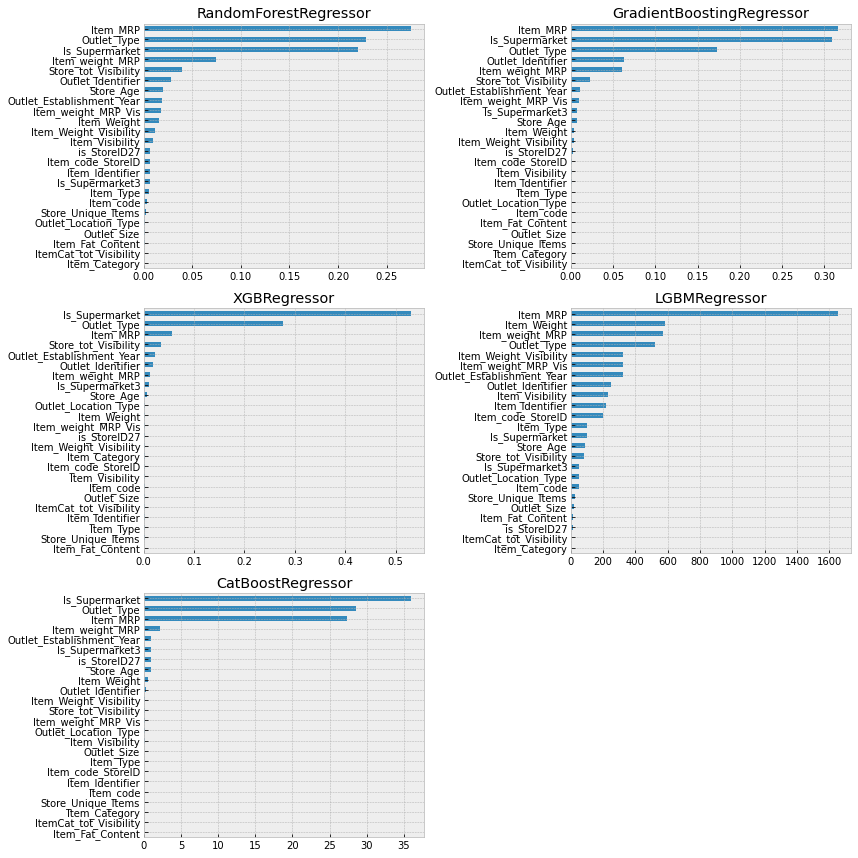

In [72]:
plt.figure(figsize=(12,12))
for i, model in enumerate([rf, gbm, xgbm, lgbm, catm], start=1):
    plt.subplot(3,2,i)
    featureImportance(model)
plt.tight_layout(pad=1.);

**Stacking**

In [73]:
linreg = LinearRegression()

In [74]:
test_stack = np.c_[rf_pred, gbm_pred, xgb_pred, lgb_pred, cat_pred]
train_stack = np.c_[rf_tr, gbm_tr, xgb_tr, lgb_tr, cat_tr]
target= train.Item_Outlet_Sales.values

In [75]:
stack_pred = StackModels(linreg, train_stack, test_stack, target)

In [76]:
stack_pred

array([1755.5637, 1339.5569,  573.0076, ..., 1940.0413, 3623.7874,
       1230.3347], dtype=float32)

In [77]:
rf_pred.max(), gbm_pred.max(), xgb_pred.max(), lgb_pred.max(), cat_pred.max(), stack_pred.max()

(6241.4736, 6154.0166, 5903.5864, 6056.0806, 5943.627, 6787.543)

**Submissions**

In [78]:
rf_df = subfile.copy()
rf_df['Item_Outlet_Sales'] = rf_pred

In [79]:
gbm_df = subfile.copy()
gbm_df['Item_Outlet_Sales'] = gbm_pred

In [80]:
lgb_df = subfile.copy()
lgb_df['Item_Outlet_Sales'] = lgb_pred

In [81]:
xgb_df = subfile.copy()
xgb_df['Item_Outlet_Sales'] = xgb_pred

In [82]:
cat_df = subfile.copy()
cat_df['Item_Outlet_Sales'] = cat_pred

In [83]:
stack_df = subfile.copy()
stack_df['Item_Outlet_Sales'] = stack_pred

In [84]:
preds = pd.DataFrame(np.c_[rf_pred, gbm_pred, xgb_pred, lgb_pred, cat_pred, stack_pred], 
                     columns=['rf', 'gbm', 'xgb', 'lgb', 'cat', 'stack'])

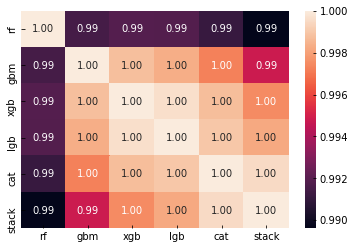

In [85]:
sns.heatmap(preds.corr(), annot=True, fmt='.2f');

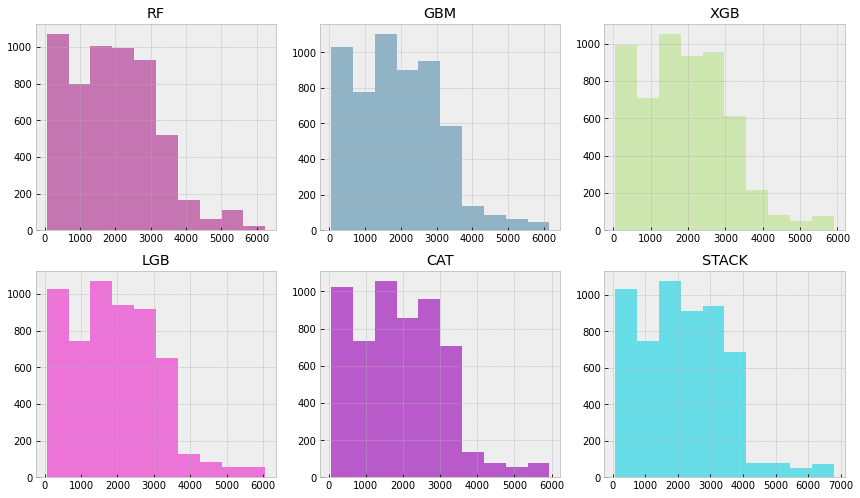

In [86]:
plt.figure(figsize=(12,7))
for i, (model_pred, model_title) in enumerate(zip([rf_pred, gbm_pred, xgb_pred, lgb_pred, cat_pred, stack_pred], 
                                                ['RF', 'GBM', 'XGB', 'LGB', 'CAT', 'STACK']), start=1):
    plt.subplot(2,3,i)
    plt.hist(model_pred, color=randomColors(), alpha=0.75)
    plt.title(model_title)
plt.tight_layout(pad=1.);

**Saving Submissions**

In [87]:
rf_df.to_csv(path+'/predictions/rf2.csv', index=False)
gbm_df.to_csv(path+'/predictions/gbm2.csv', index=False)
xgb_df.to_csv(path+'/predictions/xgb2.csv', index=False)
lgb_df.to_csv(path+'/predictions/lgb2.csv', index=False)
cat_df.to_csv(path+'/predictions/cat2.csv', index=False)
stack_df.to_csv(path+'/predictions/stack2.csv', index=False)

In [88]:
gc.collect()

54401